# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
import numpy as np
import torch
import torchinfo
from sklearn import datasets

In [4]:
import polcanet.reports as report
import polcanet.utils as ut
from polcanet import PolcaNet

Current default figure size: [3.5, 2.625]
New default figure size: [5.25, 3.9375]


In [5]:
import random

random_seed = 5
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

exp = ut.ExperimentInfoHandler(
    name="digits_dataset_8",
    description="POLCA-Net on digits dataset",
    random_seed=random_seed,
)
ut.set_save_fig(True)
ut.set_save_path(str(exp.get_experiment_folder()))
print(f"Saving Images: {ut.get_save_fig()}, saving in path: {ut.get_save_path()}")

Saving Images: True, saving in path: /data1/deploy/polcanet/examples/notebooks/experiments/digits_dataset_8_labels


### Load dataset

In [13]:
digits = datasets.load_digits()
X = digits.data / 16.0
y = digits.target
print(X.min(), X.max())
X.shape, y.shape

0.0 1.0


((1797, 64), (1797,), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

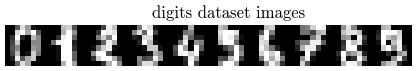

In [14]:
images = X.reshape(X.shape[0], 8, 8)
ut.set_fig_prefix("train")
ut.plot_train_images(images, "digits dataset images", n=10)

### Fit standard sklearn PCA

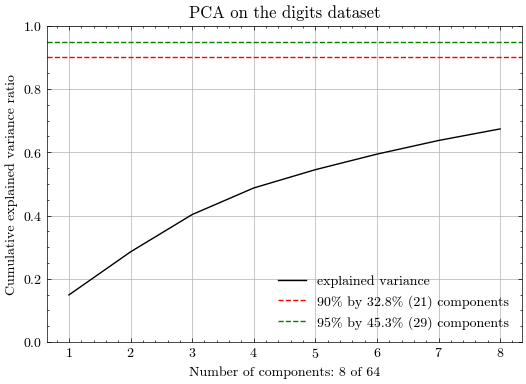

In [15]:
n_components = 8
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, layout="constrained")
pca = ut.get_pca(X, ax=axs, title="PCA on the digits dataset", n_components=n_components)
plt.show()
Xpca = pca.transform(X)

### Fit POLCANet

In [21]:
from polcanet.aencoders import DenseDecoder, DenseEncoder, LinearDecoder

ae_input = X
act_fn = torch.nn.SiLU
input_dim = (ae_input.shape[1],)
latent_dim = pca.n_components

encoder = DenseEncoder(
    input_dim=input_dim,
    latent_dim=latent_dim,
    num_layers=1,
    act_fn=act_fn,
    first_layer_size=256,
    # hidden_size=512,
)

decoder = LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=256,
    num_layers=3,
    act_fn=act_fn,
    bias=True,
)

model = PolcaNet(
    encoder=encoder,
    decoder=decoder,
    latent_dim=latent_dim,
    alpha=1.0,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=0.0,  # variance reduction loss
    device="cuda",
    center=True,
    factor_scale=True,
)
print(model)
summary = torchinfo.summary(
    model,
    (1, input_dim[0]),
    dtypes=[torch.float],
    verbose=1,
    col_width=16,
    col_names=["kernel_size", "output_size", "num_params"],
    row_settings=["var_names"],
)
ut.save_text(str(model), "model.txt")
ut.save_text(str(summary), "model_summary.txt")

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): Sequential(
      (0): DenseEncoder(
        (encoder): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features=132, bias=True)
          (3): SiLU()
          (4): Linear(in_features=132, out_features=8, bias=True)
        )
      )
      (1): Softsign()
    )
    (classifier): Linear(in_features=8, out_features=10, bias=True)
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=8, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): SiLU()
      (4): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (polca_loss): PolcaNetLoss()
)
Layer (type (var_name))                       Kernel Shape     Output Shape     Param #
PolcaNet (PolcaNet)                           --               [1, 8]           --
├─EncoderWrapper (enc

In [22]:
model.to("cuda")
model.train_model(data=X, batch_size=256, num_epochs=10000, report_freq=20, lr=1e-3)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 10000
Total Loss: 0.07413
Reconstruction Loss: 0.01428
Orthogonality Loss: 0.03213
Center of Mass Loss: 0.0121
Variance Reduction Loss: 0.01287
Classification Loss: 0.002764


np.float64(0.07413180219009519)

In [23]:
model.train_model(data=X, batch_size=256, num_epochs=5000, report_freq=20, lr=1e-4)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 0.05965
Reconstruction Loss: 0.009848
Orthogonality Loss: 0.02733
Center of Mass Loss: 0.01025
Variance Reduction Loss: 0.009615
Classification Loss: 0.0026


np.float64(0.05964656127616763)

In [24]:
model.train_model(data=X, batch_size=256, num_epochs=5000, report_freq=20, lr=1e-5)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 0.047
Reconstruction Loss: 0.008906
Orthogonality Loss: 0.01613
Center of Mass Loss: 0.009547
Variance Reduction Loss: 0.009709
Classification Loss: 0.002708


np.float64(0.04699955275282264)

## Evaluate results

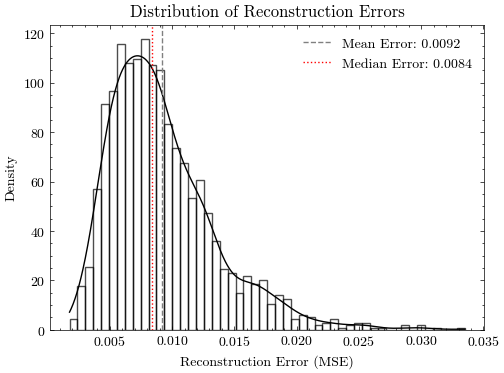

Mean Reconstruction Error: 0.0092
Median Reconstruction Error: 0.0084
Min Reconstruction Error: 0.0018
Max Reconstruction Error: 0.0335


In [25]:
report.analyze_reconstruction_error(model, X)

In [26]:
latents, reconstructed = model.predict(X)

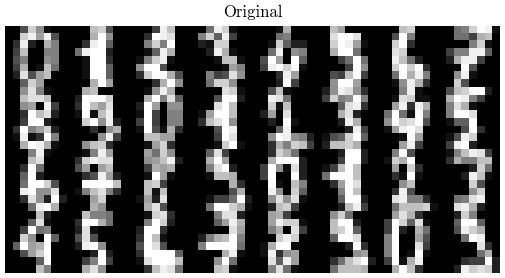

n_components: 2


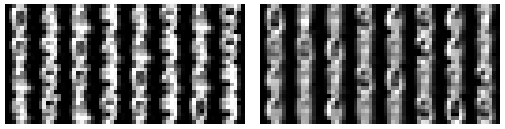

n_components: 4


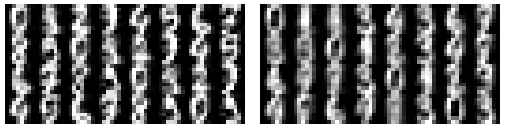

n_components: 6


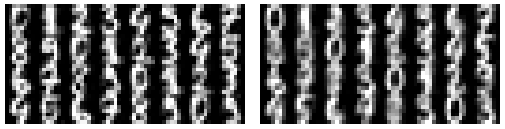

n_components: 8


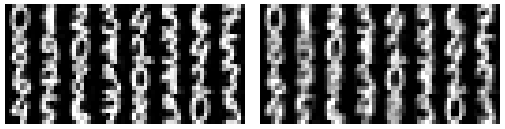

In [27]:
N = 32
# Assuming images are properly defined as before
images_to_show = images[:N]
ut.visualise_reconstructed_images([images_to_show], ["Original"], cmap="gray", nrow=8)
for i in range(2, 9, 2):
    print("n_components:", i)
    ut.plot_reconstruction_comparison(
        model, pca, images_to_show, cmap="gray", nrow=8, n_components=i, no_title=True, show_only_reconstruction=True
    )


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: -0.0030
    - Max cosine similarity: 0.0478
    - Min cosine similarity: -0.0852
    


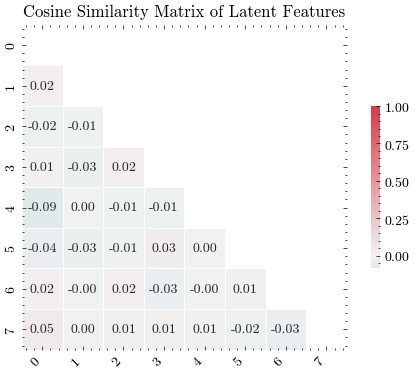

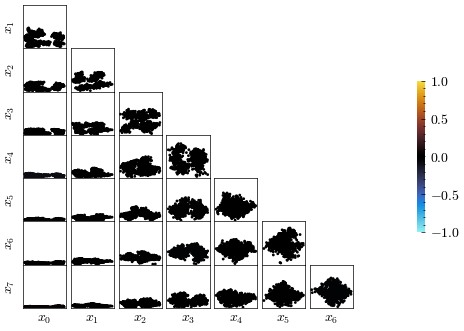

In [28]:
report.orthogonality_test_analysis(model, X)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.2446
    - Variance fit to exponential distribution (sum of squared differences):
     0.0626
    


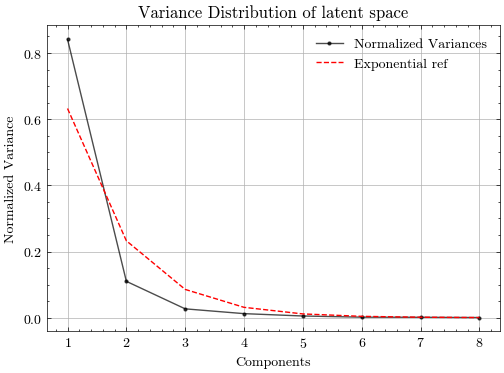

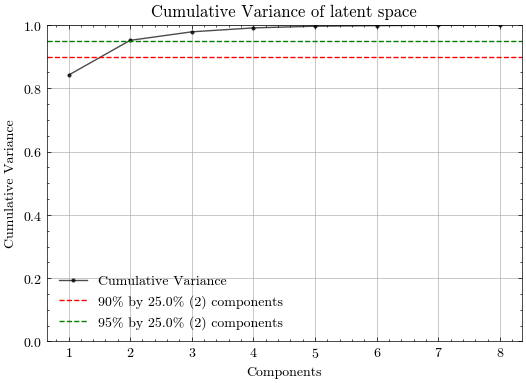

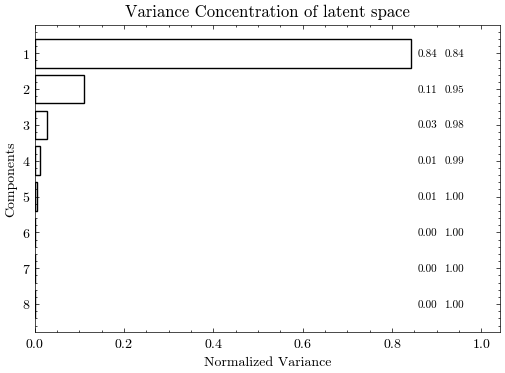

In [29]:
report.variance_test_analysis(model, X)

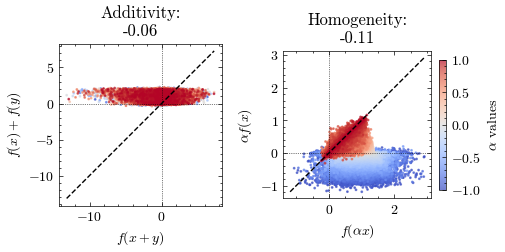

In [30]:
report.linearity_tests_analysis(model, X)

## Polca Net vs. PCA

In [31]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    _, _ = ut.plot2d_analysis(Xpca, y, title="PCA transform", legend=True)
with o2:
    _, _ = ut.plot2d_analysis(latents, y, title="POLCA-Net latent", legend=True)

layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

## Test Classification with two components on PCA vs POLCA Net

In [32]:
_ = ut.make_classification_report(model, pca, X, y, n_components=pca.n_components)

output shape from pca (1257, 8) (540, 8)
output shape from POLCA (1257, 8) (540, 8)
Performance Metrics DataFrame:


/data1/conda/envs/python3.12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/data1/conda/envs/python3.12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/data1/conda/envs/python3.12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/data1/conda/envs/python3.12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Accuracy       Error rate       Matthews       F1-Score  \
Transformation            PCA POLCA        PCA POLCA      PCA POLCA      PCA   
Classifier                                                                     
Gaussian Naive Bayes     0.86   1.0      13.89  0.00     0.85   1.0     0.86   
Linear SVM               0.91   1.0       9.44  0.00     0.90   1.0     0.91   
Logistic Regression      0.85   1.0      14.63  0.00     0.84   1.0     0.85   
Perceptron               0.76   1.0      24.07  0.00     0.75   1.0     0.73   
Ridge Classifier         0.81   1.0      18.70  0.37     0.79   1.0     0.81   

                            
Transformation       POLCA  
Classifier                  
Gaussian Naive Bayes   1.0  
Linear SVM             1.0  
Logistic Regression    1.0  
Perceptron             1.0  
Ridge Classifier       1.0


Wilcoxon Signed-Rank Test Results DataFrame:


,Wilcoxon Test,P-Value,Significant (p < 0.05)
Accuracy,0.0,0.0625,No better method
Error rate,0.0,0.0625,No better method
Matthews,0.0,0.0625,No better method
F1-Score,0.0,0.0625,No better method


In [33]:
experiment_data = {
    "digits": (
        images,
        model,
        pca,
    ),
}
_ = ut.image_metrics_table(experiment_data)

,NMSE,PSNR,SSI
Method,,,
POLCA digits,0.0403,20.7864,0.9606
PCA digits,0.1044,16.5581,0.8919
